In [1]:
# Import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Create SparkSession

spark = SparkSession.builder.appName('Demand Prediction').getOrCreate()

from pyspark.sql.functions import col

23/06/06 20:34:48 WARN Utils: Your hostname, yaomaojiadeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.74 instead (on interface en0)
23/06/06 20:34:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/06 20:34:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load data

# 1.Aggregate data
data = spark.read.format("csv").option("header", "true").load("data/Aggregate/daily_demand_totals.csv")

# 2.Concrete data
# data = spark.read.format("csv").option("header", "true").load("data/Concrete/daily_demand_totals.csv")

In [4]:
data.show()

+-------------------+------+
|          timestamp|demand|
+-------------------+------+
|2020-01-01 00:00:00|  9446|
|2020-01-02 00:00:00|  9433|
|2020-01-03 00:00:00|  9424|
|2020-01-04 00:00:00|  9454|
|2020-01-05 00:00:00|  9468|
|2020-01-06 00:00:00|  7509|
|2020-01-07 00:00:00|  7531|
|2020-01-08 00:00:00|  9429|
|2020-01-09 00:00:00|  9453|
|2020-01-10 00:00:00|  9457|
|2020-01-11 00:00:00|  9420|
|2020-01-12 00:00:00|  9447|
|2020-01-13 00:00:00|  7551|
|2020-01-14 00:00:00|  7568|
|2020-01-15 00:00:00|  9465|
|2020-01-16 00:00:00|  9420|
|2020-01-17 00:00:00|  9461|
|2020-01-18 00:00:00|  9426|
|2020-01-19 00:00:00|  9450|
|2020-01-20 00:00:00|  7573|
+-------------------+------+
only showing top 20 rows



In [5]:
# Convert the 'demand' column to a numeric type
data = data.withColumn("demand", col("demand").cast("double"))

# Data cleaning and preparation
data = data.dropna()
data = data.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("year", year(col("timestamp")))
data = data.withColumn("month", month(col("timestamp")))
data = data.withColumn("day", dayofmonth(col("timestamp")))
data = data.withColumn("day_of_week", dayofweek(col("timestamp")))
data = data.withColumn("is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0))

In [6]:
def transform(data):
    # Feature engineering
    assembler = VectorAssembler(inputCols=["month", "day", "day_of_week", "is_weekend"], outputCol="features")
    data = assembler.transform(data)
    
    # One-Hot encoding of all features
    encoded_cols = []
    for col_name in ["month", "day", "day_of_week", "is_weekend"]:
        # Convert categorical features to numeric index
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
        data = indexer.fit(data).transform(data)
        
        # One-Hot Encoding of Numeric Index
        encoder = OneHotEncoder(inputCols=[f"{col_name}_index"], outputCols=[f"{col_name}_encoded"])
        data = encoder.fit(data).transform(data)
        
        # Record the encoded column names
        encoded_cols.append(f"{col_name}_encoded")
        
    assembler = VectorAssembler(inputCols=encoded_cols, outputCol="encoded_features")
    data = assembler.transform(data)
    return data

data = transform(data)

In [7]:
# Divide the dataset into training and testing sets
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

# Data Exploration

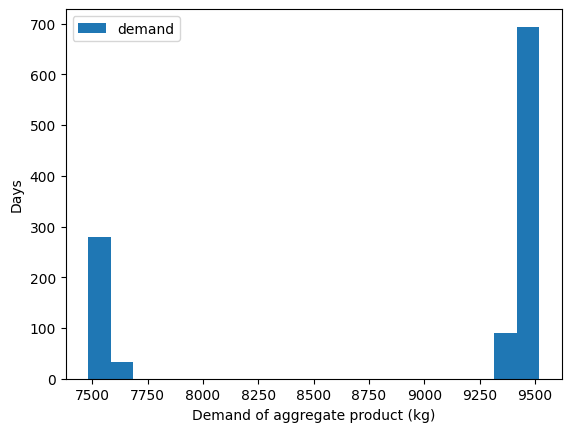

In [8]:
# Draw a histogram of demand to see the distribution of data

demand = pd.DataFrame(data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='hist', bins=20)
plt.xlabel('Demand of aggregate product (kg)')
plt.ylabel('Days')
plt.show()

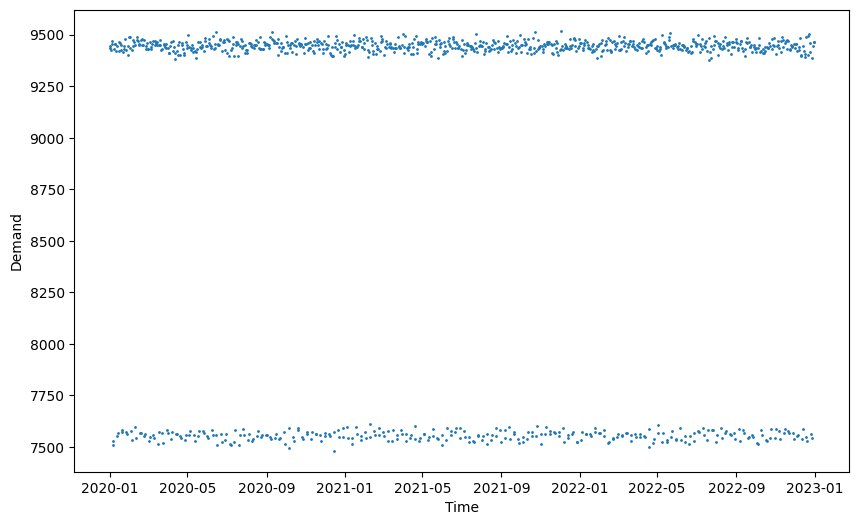

In [9]:
# Draw a scatterplot of demand and time and see the shape of data distribution

data = data.select('timestamp', 'demand').toPandas()
data['timestamp'] = pd.to_datetime(data['timestamp'])
plt.figure(figsize=(10, 6))
plt.scatter(data['timestamp'], data['demand'], s=1)
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

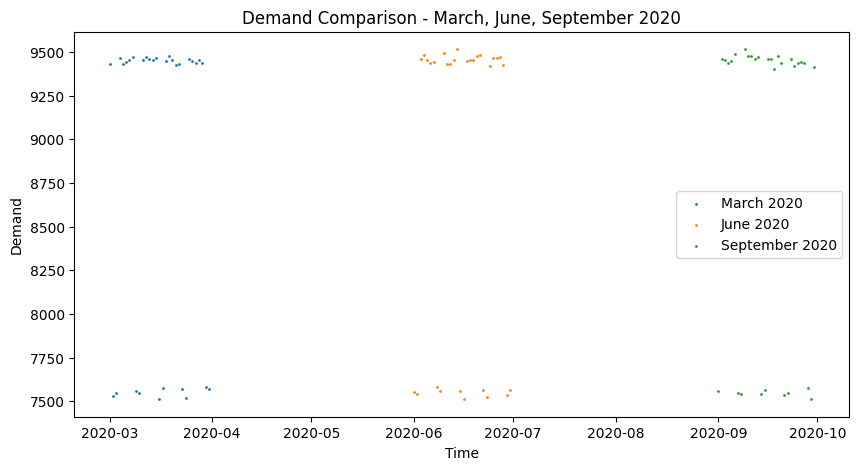

According to the graph, it can be seen that the change in demand changes slightly with the month


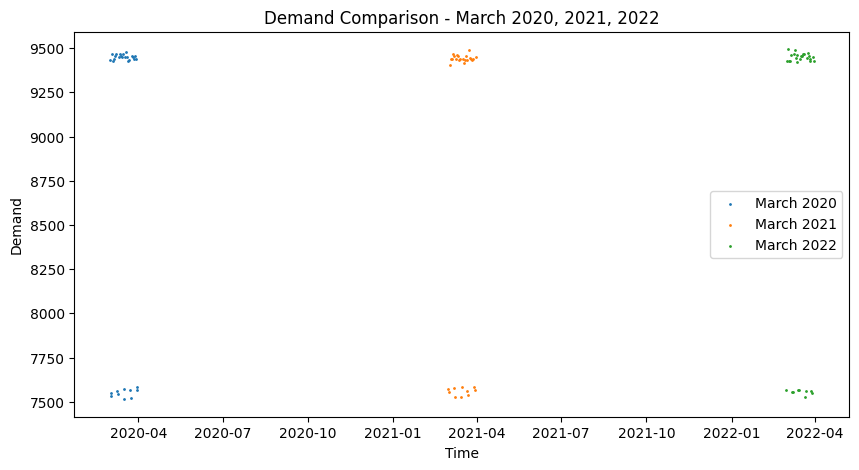

According to the graph, it can be seen that the change in demand changes slightly with the year


In [10]:
# Compare the data of March, June and September of 2020 by the same day
data_2020 = data[data['timestamp'].dt.year == 2020]
data_2020_03 = data_2020[data_2020['timestamp'].dt.month == 3]
data_2020_06 = data_2020[data_2020['timestamp'].dt.month == 6]
data_2020_09 = data_2020[data_2020['timestamp'].dt.month == 9]

# Draw a scatterplot for March, June, and September of 2020
plt.figure(figsize=(10, 5))
plt.scatter(data_2020_03['timestamp'], data_2020_03['demand'], s=1, label='March 2020')
plt.scatter(data_2020_06['timestamp'], data_2020_06['demand'], s=1, label='June 2020')
plt.scatter(data_2020_09['timestamp'], data_2020_09['demand'], s=1, label='September 2020')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand Comparison - March, June, September 2020')
plt.legend()
plt.show()

print("According to the graph, it can be seen that the change in demand changes slightly with the month")

# Compare the data for March 2020, March 2021 and March 2022 by the same day
data_mar = data[data['timestamp'].dt.month == 3]
data_2020_03 = data_mar[data_mar['timestamp'].dt.year == 2020]
data_2021_03 = data_mar[data_mar['timestamp'].dt.year == 2021]
data_2022_03 = data_mar[data_mar['timestamp'].dt.year == 2022]

# Draw a scatterplot for March 2020, March 2021 and March 2022
plt.figure(figsize=(10, 5))
plt.scatter(data_2020_03['timestamp'], data_2020_03['demand'], s=1, label='March 2020')
plt.scatter(data_2021_03['timestamp'], data_2021_03['demand'], s=1, label='March 2021')
plt.scatter(data_2022_03['timestamp'], data_2022_03['demand'], s=1, label='March 2022')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand Comparison - March 2020, 2021, 2022')
plt.legend()
plt.show()

print("According to the graph, it can be seen that the change in demand changes slightly with the year")

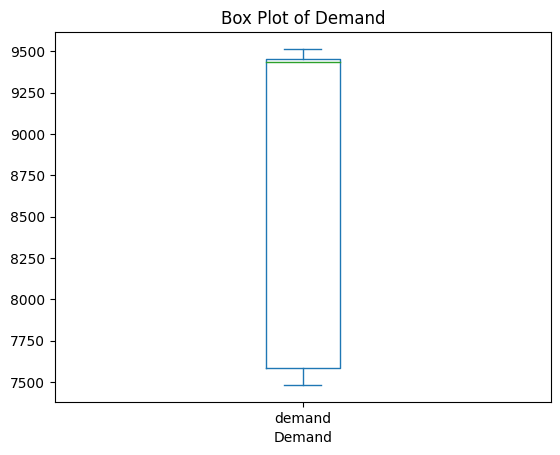

In [11]:
# Use Boxplot to detect outliers and the shape of data distribution

demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='box')
plt.title('Box Plot of Demand')
plt.xlabel('Demand')
plt.show()

# Model Training and Prediction

## 1. Linear Regression

In [12]:
# Define linear regression model
lr = LinearRegression(featuresCol="encoded_features", labelCol="demand", regParam=0.01)

# Training linear regression model
lr_model = lr.fit(train_data)

# Predict future demand using linear regression model
lr_predictions = lr_model.transform(test_data)

# Calculate the evaluation metrics (MSE, RMSE and R²) of the linear regression model 
lr_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
lr_mse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mse"})
lr_rmse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "rmse"})
lr_r2 = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"})

# Show prediction results
lr_predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output evaluation results
print("Linear Regression MSE on test data = {:.4f}".format(lr_mse))
print("Linear Regression RMSE on test data = {:.4f}".format(lr_rmse))
print("Linear Regression R² on test data = {:.4f}".format(lr_r2))


23/06/06 20:35:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/06 20:35:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9447.780490907273|
|2020|    1| 11|          7|         1|9420.0|9449.350944434744|
|2020|    1| 12|          1|         1|9447.0|9441.593972661793|
|2020|    1| 15|          4|         0|9465.0| 9444.47603818777|
|2020|    1| 16|          5|         0|9420.0| 9440.90138239212|
|2020|    1| 20|          2|         0|7573.0|7556.914935803207|
|2020|    1| 21|          3|         0|7581.0|7561.133357302633|
|2020|    1| 26|          1|         1|9426.0|9444.661718507841|
|2020|    1| 30|          5|         0|9446.0|9450.581462428348|
|2020|    2|  4|          3|         0|7535.0|7561.887978438728|
|2020|    2|  5|          4|         0|9425.0|9437.984611486241|
|2020|    2|  7|          6|         0|9446.0|9442.169153453433|
|2020|    2|  8|         

## 2. Random Forest Regression

In [13]:
# Define random forest regression model
rf = RandomForestRegressor(featuresCol="encoded_features", labelCol="demand", numTrees=1)

# Training random forest regression model
rf_model = rf.fit(train_data)

# Predict future demand using random forest regression model
rf_predictions = rf_model.transform(test_data)

# Calculate the evaluation metrics (MSE, RMSE and R²) of the random forest regression model
rf_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
rf_mse = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "mse"})
rf_rmse = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "rmse"})
rf_r2 = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "r2"})

# Show prediction results
rf_predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output evaluation results
print("Random Forest MSE on test data = {:.4f}".format(rf_mse))
print("Random Forest RMSE on test data = {:.4f}".format(rf_rmse))
print("Random Forest R² on test data = {:.4f}".format(rf_r2))


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9444.356435643564|
|2020|    1| 11|          7|         1|9420.0|9444.356435643564|
|2020|    1| 12|          1|         1|9447.0|9453.414141414141|
|2020|    1| 15|          4|         0|9465.0|9439.194174757282|
|2020|    1| 16|          5|         0|9420.0|9445.918367346938|
|2020|    1| 20|          2|         0|7573.0|7555.986842105263|
|2020|    1| 21|          3|         0|7581.0|7558.178571428572|
|2020|    1| 26|          1|         1|9426.0|9453.414141414141|
|2020|    1| 30|          5|         0|9446.0|9445.918367346938|
|2020|    2|  4|          3|         0|7535.0|7558.178571428572|
|2020|    2|  5|          4|         0|9425.0|9439.194174757282|
|2020|    2|  7|          6|         0|9446.0|9447.950495049505|
|2020|    2|  8|         

## 3. Gradient Boosted Tree Regression

In [14]:
# Define gradient boosted tree regression model
gbt = GBTRegressor(featuresCol="encoded_features", labelCol="demand", maxIter=10)

# Training gradient boosted tree regression model
gbt_model = gbt.fit(train_data)

# Predict future demand using gradient boosted tree regression model
gbt_predictions = gbt_model.transform(test_data)

# Calculate the evaluation metrics (MSE, RMSE and R²) of the gradient boosted tree regression model
gbt_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
gbt_mse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "mse"})
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "rmse"})
gbt_r2 = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "r2"})

# Show prediction results
gbt_predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output evaluation results
print("Gradient Boosted Tree MSE on test data = {:.4f}".format(gbt_mse))
print("Gradient Boosted Tree RMSE on test data = {:.4f}".format(gbt_rmse))
print("Gradient Boosted Tree R² on test data = {:.4f}".format(gbt_r2))


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9448.704515895306|
|2020|    1| 11|          7|         1|9420.0|9420.098452994824|
|2020|    1| 12|          1|         1|9447.0|9433.818273618916|
|2020|    1| 15|          4|         0|9465.0|9442.587292760842|
|2020|    1| 16|          5|         0|9420.0|9447.635371828716|
|2020|    1| 20|          2|         0|7573.0|7556.828821523647|
|2020|    1| 21|          3|         0|7581.0|7557.661366834916|
|2020|    1| 26|          1|         1|9426.0|9448.704515895306|
|2020|    1| 30|          5|         0|9446.0| 9448.17045139117|
|2020|    2|  4|          3|         0|7535.0|7557.661366834916|
|2020|    2|  5|          4|         0|9425.0|9437.677532368443|
|2020|    2|  7|          6|         0|9446.0|9452.120307545823|
|2020|    2|  8|         

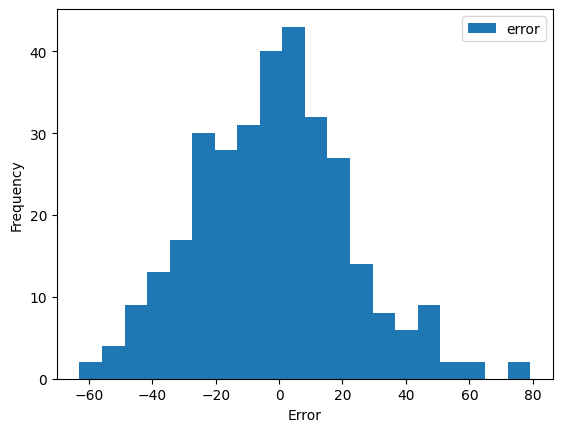

In [15]:
# Select lr_model as an example, and use the prediction error distribution chart to observe whether the prediction error of the model conforms to the normal distribution

# Calculate prediction error
lr_errors = lr_predictions.select("demand", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()

# Plotting the distribution of prediction error
pd.DataFrame(lr_errors, columns=['error']).plot(kind='hist', bins=20)
plt.xlabel('Error')
plt.show()

In [16]:
# Actual demand for test data and predicted demand from each model
real_result = [row['demand'] for row in test_data.select("demand").collect()]
lr_result = [row['prediction'] for row in lr_predictions.select("prediction").collect()]
rf_result = [row['prediction'] for row in rf_predictions.select("prediction").collect()]
gbt_result = [row['prediction'] for row in gbt_predictions.select("prediction").collect()]

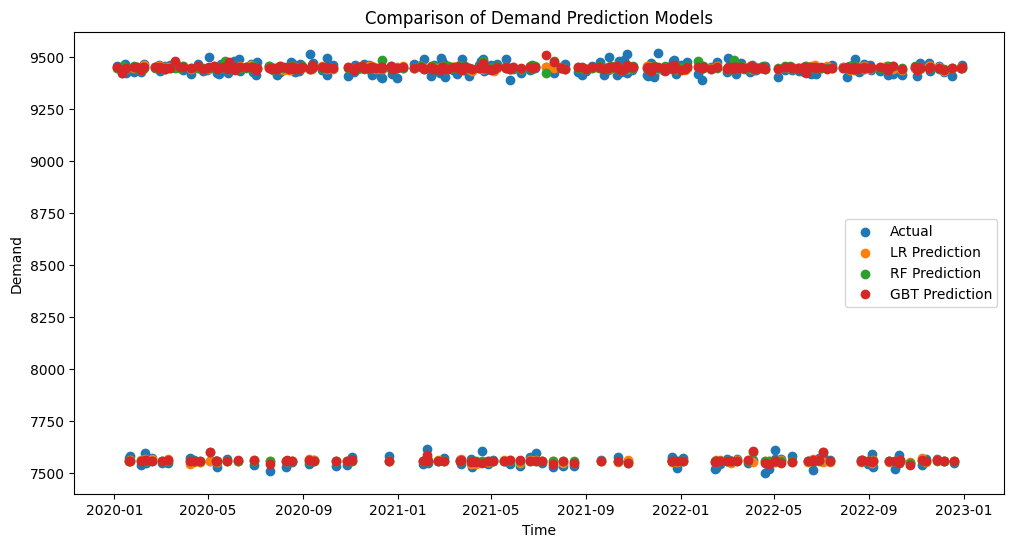

In [17]:
# Create an array of time series
time_series = test_data.select("timestamp").rdd.flatMap(lambda x: x).collect()

# Create a matplotlib chart and plot the actual demand and predictions from each model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, real_result, label="Actual")
ax.scatter(time_series, lr_result, label="LR Prediction")
ax.scatter(time_series, rf_result, label="RF Prediction")
ax.scatter(time_series, gbt_result, label="GBT Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Comparison of Demand Prediction Models")
ax.legend()

# Show the chart
plt.show()

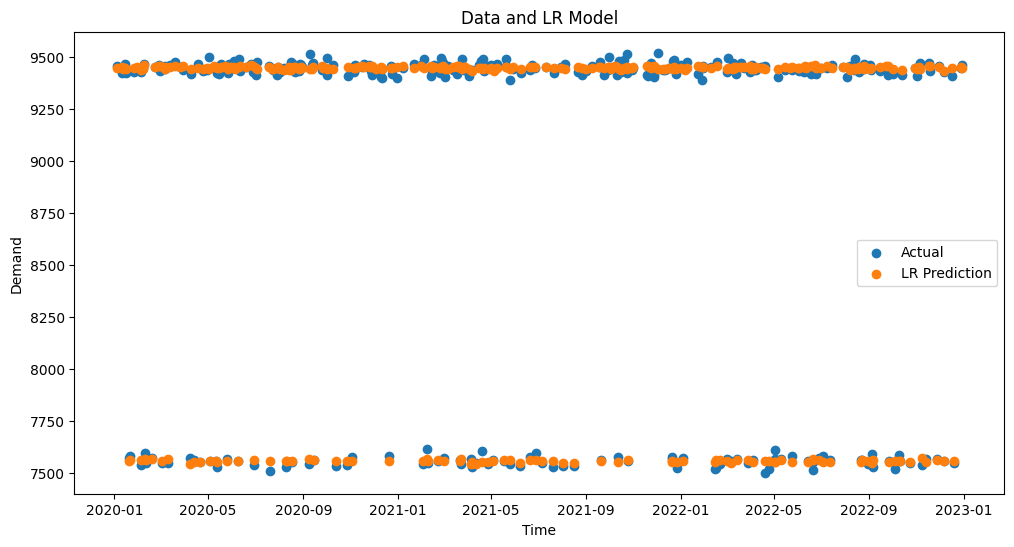

In [18]:
# Plot actual demand and forecasted demand on LR model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, real_result, label="Actual")
ax.scatter(time_series, lr_result, label="LR Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Data and LR Model")
ax.legend()

# Show the chart
plt.show()

In [19]:
# Calculate the residual value
def get_residual(a, b):
    return [a_i - b_i for a_i, b_i in zip(a, b)]
lr_residual = get_residual(real_result, lr_result)
gbt_residual = get_residual(real_result, gbt_result)
rf_residual = get_residual(real_result, rf_result)

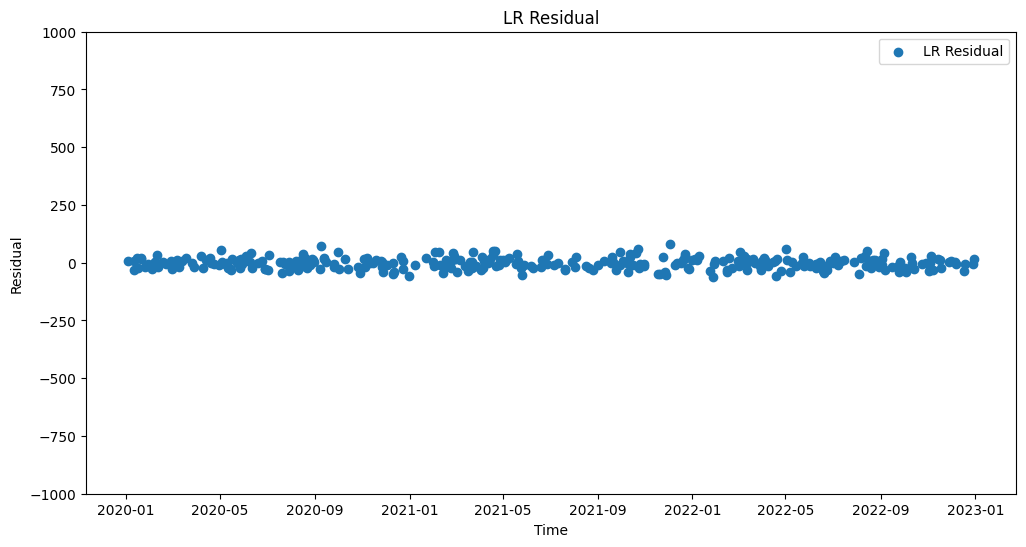

In [20]:
# Draw the residual plot of the LR model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, lr_residual, label="LR Residual")
ax.set_xlabel("Time")
ax.set_ylabel("Residual")
ax.set_title("LR Residual")
ax.legend()

# Show the chart
plt.ylim([-1000, 1000])
plt.show()

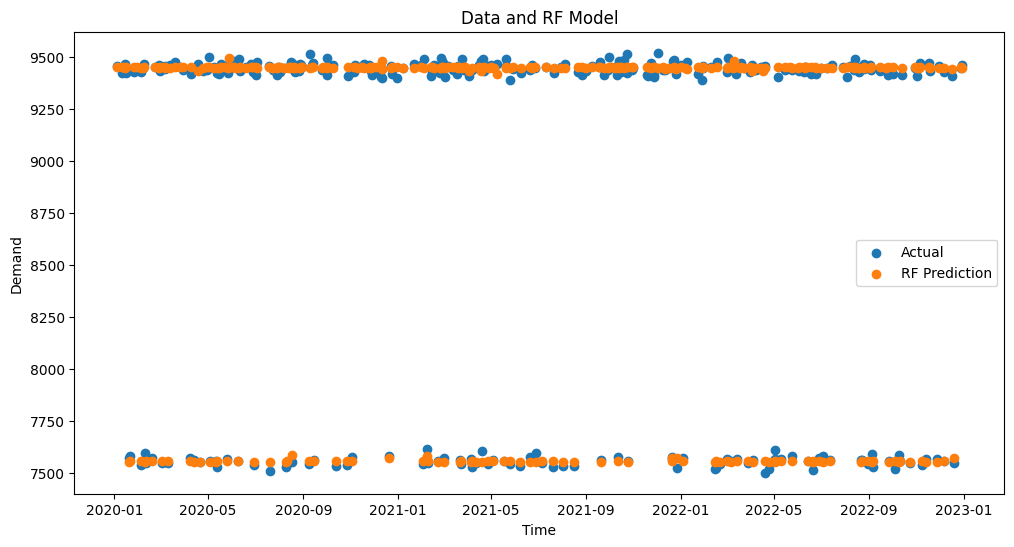

In [89]:
# Plot actual demand and forecasted demand on RF model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, real_result, label="Actual")
ax.scatter(time_series, rf_result, label="RF Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Data and RF Model")
ax.legend()

# Show the chart
plt.show()

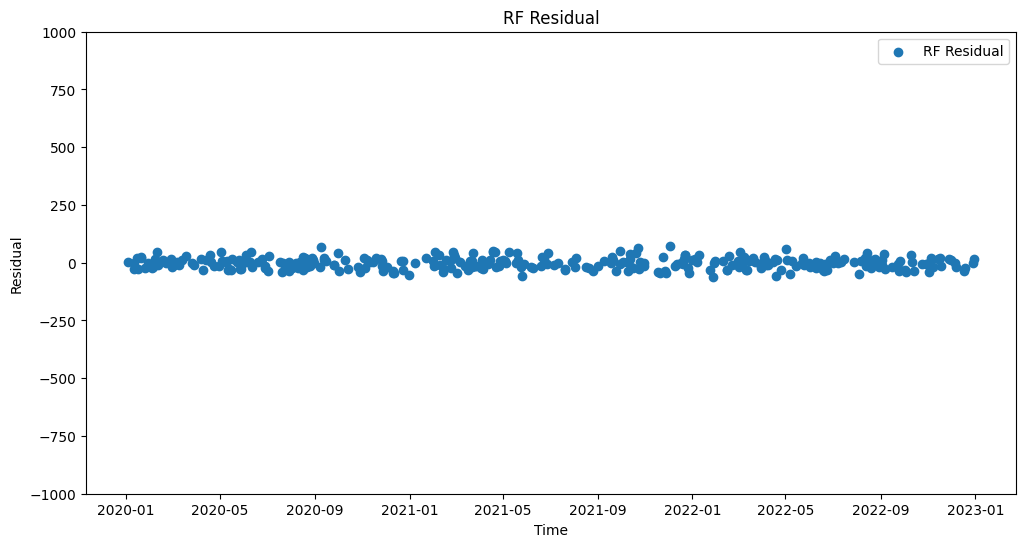

In [90]:
# Draw the residual plot of the RF model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, rf_residual, label="RF Residual")
ax.set_xlabel("Time")
ax.set_ylabel("Residual")
ax.set_title("RF Residual")
ax.legend()

# Show the chart
plt.ylim([-1000, 1000])
plt.show()

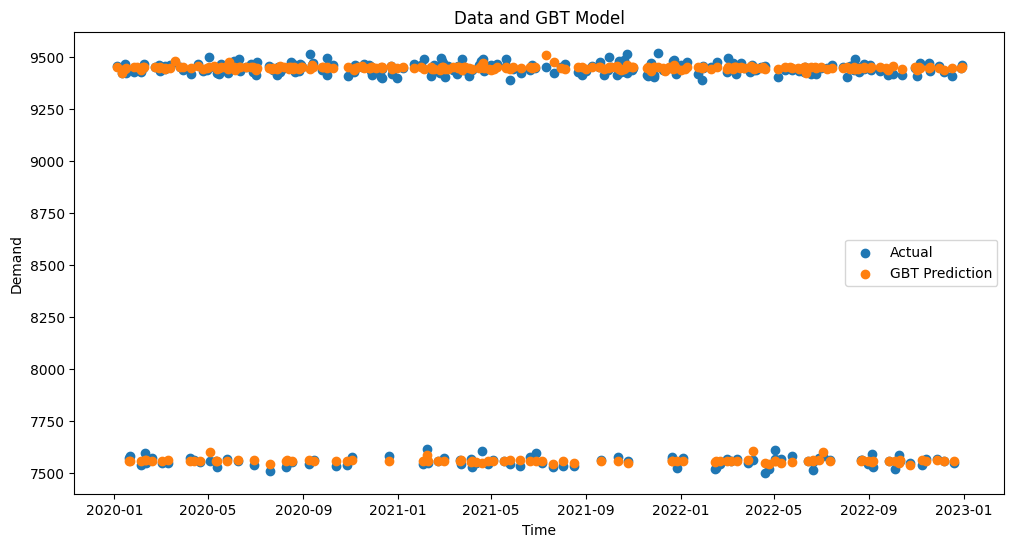

In [91]:
# Plot actual demand and forecasted demand on GBT model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, real_result, label="Actual")
ax.scatter(time_series, gbt_result, label="GBT Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Data and GBT Model")
ax.legend()

# Show the chart
plt.show()

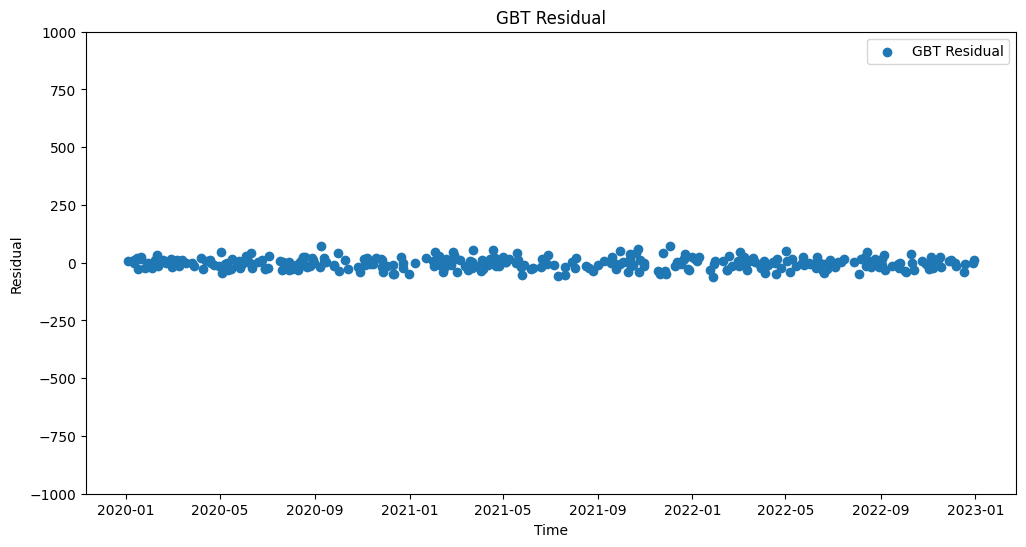

In [92]:
# Draw the residual plot of the GBT model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, gbt_residual, label="GBT Residual")
ax.set_xlabel("Time")
ax.set_ylabel("Residual")
ax.set_title("GBT Residual")
ax.legend()

# Show the chart
plt.ylim([-1000, 1000])
plt.show()

In [93]:
# Create a dictionary with the evaluation metrics
metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosted Tree'],
    'MSE': [lr_mse, rf_mse, gbt_mse],
    'RMSE': [lr_rmse, rf_rmse, gbt_rmse],
    'R²': [lr_r2, rf_r2, gbt_r2]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)

                   Model         MSE       RMSE        R²
0      Linear Regression  584.255323  24.171374  0.999199
1          Random Forest  587.024489  24.228588  0.999195
2  Gradient Boosted Tree  570.949206  23.894543  0.999217


In [94]:
print('After one-hot encoding of all features in feature engineering, the MSE, RMSE and R² evaluation values \
of the three models of linear regression, random forest regression and gradient boosted tree regression have been \
optimized, and the best optimization is linear regression model. The lower the value of MSE and RMSE, the higher \
the value of R² is better. After optimization, the three evaluation metrics of the three models are not much \
different, and the gradient boosted tree regression model with the smallest MSE and RMSE values and the highest R² \
is selected as the final inventory forecasting model')

After one-hot encoding of all features in feature engineering, the MSE, RMSE and R² evaluation values of the three models of linear regression, random forest regression and gradient boosted tree regression have been optimized, and the best optimization is linear regression model. The lower the value of MSE and RMSE, the higher the value of R² is better. After optimization, the three evaluation metrics of the three models are not much different, and the gradient boosted tree regression model with the smallest MSE and RMSE values and the highest R² is selected as the final inventory forecasting model


In [98]:
import calendar
from datetime import datetime

# Generate feature data for 2023
features_2023 = []
for month in range(1, 13):
    for day in range(1, calendar.monthrange(2023, month)[1] + 1):
        day_of_week = datetime(2023, month, day).weekday()
        is_weekend = 1 if day_of_week in (5, 6) else 0
        features_2023.append((2023, month, day, day_of_week, is_weekend))

In [99]:
# Convert feature data to DataFrame
features_2023_df = spark.createDataFrame(features_2023, ["year", "month", "day", "day_of_week", "is_weekend"])

# Generating feature vectors using feature engineering
features_2023_df = transform(features_2023_df)

# Prediction using Gradient Boosted Tree Models
predictions_2023 = gbt_model.transform(features_2023_df)

# Convert prediction results to Pandas DataFrame
predictions_2023_df = predictions_2023.select("year", "month", "day", "prediction").toPandas()
predictions_2023_df['timestamp'] = pd.to_datetime(predictions_2023_df[['year', 'month', 'day']])

# Keep 2 decimal places
predictions_2023_df['prediction'] = predictions_2023_df['prediction'].round(2)

# Save prediction results to CSV file
# Aggregate CSV file
predictions_2023_df.to_csv("data/Aggregate/predictions_2023.csv", index=False)

# Concrete CSV file
# predictions_2023_df.to_csv("data/Concrete/predictions_2023.csv", index=False)

In [100]:
origin_data = spark.read.format("csv").option("header", "true").load("data/Aggregate/daily_demand_totals.csv")
origin_data = origin_data.withColumn("demand", col("demand").cast("double"))

# Data cleaning and preparation
origin_data = origin_data.dropna()
origin_data = origin_data.withColumn("date", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
origin_data_df = origin_data.toPandas()

In [101]:
origin_data_df
predictions_df = predictions_2023_df[['timestamp', 'prediction']]
predictions_df = predictions_df.rename(columns={'prediction': 'demand'})
predictions_df

,timestamp,demand
0,2023-01-01,9433.97
1,2023-01-02,9444.16
2,2023-01-03,9446.29
3,2023-01-04,7557.66
4,2023-01-05,7552.75
...,...,...
360,2023-12-27,7556.09
361,2023-12-28,7556.09
362,2023-12-29,7556.37
363,2023-12-30,9447.14


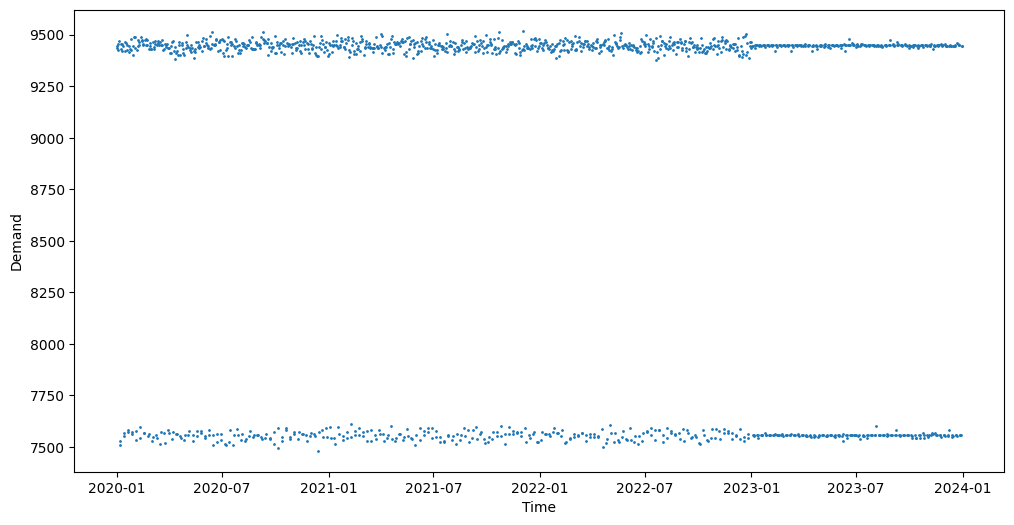

In [102]:
full_data_df = pd.concat([origin_data_df, predictions_df])
full_data_df['timestamp'] = pd.to_datetime(full_data_df['timestamp'])
ax = full_data_df.plot(x='timestamp', y='demand', kind='scatter', s=1)
ax.get_figure().set_size_inches(12, 6)
plt.xlabel('Time')
plt.ylabel('Demand')

#show the plot
plt.show()